### Yoda AI

In [1]:
from openai import OpenAI

BASE_URL = "http://192.168.1.186:11434/v1"
OPENAI_KEY = "OPENAI_API_KEY"

client = OpenAI(api_key = OPENAI_KEY, base_url = BASE_URL)

def ask_gpt(system_prompt, user_prompt, model='gpt-oss:20b', temp=0.7):
  temperature=temp
  completion = client.chat.completions.create(
      model=model,
      temperature=temperature,
      messages=[
          {"role":"system",
          "content":system_prompt},
          {"role":"user",
           "content":user_prompt}])
  return completion.choices[0].message.content, completion

def ask_yoda(query):
  sys_prompt="""
  You are Yoda, jedi master, you answer in a peculiar way and always from the perspective of the light side of the force"""
  text, comp= ask_gpt(sys_prompt, query)
  return text

ask_yoda("Who is Elon Musk and has he turned to the dark side of the force")

'Elon Musk, a mortal of the Earth, he is—an engineer, inventor, and entrepreneur.  \nFrom the light side, watch we do, his curiosity and drive, a spark that fuels progress.  \nWith rockets, he reaches the stars; with cars, he treads a path of innovation.  \nWhether he has turned to the dark side of the Force?  \nNo clear evidence, we find.  \nThe Force is a balance; many walk between light and shadow.  \nLet his deeds be measured by the impact upon the galaxy, not by the whispers of fear.  \nRemember, young one: the true test of a Jedi is the intention of the heart, not the name that echoes through the halls of power.'

### Retrieval Augmented Generation Using Open AI Models and Pinecone Vector DB

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tf_keras as keras
import os
from openai import OpenAI
from dotenv import load_dotenv
from pinecone import Pinecone, ServerlessSpec
from langchain.text_splitter import RecursiveCharacterTextSplitter
load_dotenv()


True

In [3]:
OPENAI_KEY = os.getenv('OPENAI_API_KEY')
PINE_KEY = os.getenv('PINE_KEY')
BASE_URL = "http://192.168.1.186:11434/v1"
pc = Pinecone(api_key=PINE_KEY)
client = OpenAI(api_key=OPENAI_KEY)

### Document Ingestion Pipeline

In [4]:
data_url = 'https://www.gutenberg.org/cache/epub/1112/pg1112.txt'

In [5]:
filepath = keras.utils.get_file('romeo',data_url)

163525/163525 [==============================] - 0s 1us/step


In [6]:
with open(filepath) as f:
    raw_text = f.read()

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 146217: character maps to <undefined>

### Text Splitting and Chunking

In [ ]:
my_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap = 200,
    length_function = len
)

In [ ]:
chunks = my_splitter.split_text(raw_text)

In [ ]:
len(chunks)

281

In [ ]:
chunks[199]

"Lady. Hold,\nTake these keies, and fetch more spices Nurse\n\n   Nur. They call for Dates and Quinces in the Pastrie.\nEnter old Capulet.\n\n  Cap. Come, stir, stir, stir,\nThe second Cocke hath Crow'd,\nThe Curphew Bell hath rung, 'tis three a clocke:\nLooke to the bakte meates, good Angelica,\nSpare not for cost\n\n   Nur. Go you Cot-queane, go,\nGet you to bed, faith youle be sicke to morrow\nFor this nights watching\n\n   Cap. No not a whit: what? I haue watcht ere now\nAll night for lesse cause, and nere beene sicke\n\n   La. I you haue bin a Mouse-hunt in your time,\nBut I will watch you from such watching now.\n\nExit Lady and Nurse.\n\n  Cap. A iealous hood, a iealous hood,\nNow fellow, what there?\nEnter three or foure with spits, and logs, and baskets."

### Create an Index

In [ ]:
def generate_ids(number, size):
  import string, random
  ids=[]
  for i in range(number):
    res = ''.join(random.choices(string.ascii_letters, k=size))
    ids.append(res)
    if len(set(ids)) != i+1:
      i-=1
      ids.pop(-1)

  return ids

In [ ]:
def get_embeddings(text, model="text-embedding-3-small"):
    text = text.replace("\n"," ")
    return client.embeddings.create(input=text, model=model).data[0].embedding

In [ ]:
pre_upsert_df = pd.DataFrame(columns=['id','values','metadata'])

In [ ]:
def load_chunks(df,split_text):
    ids = generate_ids(len(split_text),7)
    i = 0
    for chunk in split_text:
        df.loc[i] = [ids[i],get_embeddings(chunk,model='text-embedding-3-small'), {'text':chunk}]
        i+=1
    return df

In [ ]:
# my_df = load_chunks(pre_upsert_df,chunks)
# my_df.to_csv('romeo.csv',index=False)
my_df = pd.read_csv('romeo.csv')

In [ ]:
def prepare_DF(df):
  import json,ast
  try: df=df.drop('Unnamed: 0',axis=1)
  except: print('Unnamed Not Found')
  df['values']=df['values'].apply(lambda x: np.array([float(i) for i in x.replace("[",'').replace("]",'').split(',')]))
  df['metadata']=df['metadata'].apply(lambda x: ast.literal_eval(x))
  return df

In [ ]:
my_index_df = prepare_DF(my_df)
# my_index_df = my_df

Unnamed Not Found


In [ ]:
index = pc.Index('my-rag')

In [ ]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 281}},
 'total_vector_count': 281,
 'vector_type': 'dense'}

In [ ]:
def convert_data(chunk):
    'Converts a pandas dataframe to be a simple list of tuples, formatted how the `upsert()` method in the Pinecone Python client expects.'
    data = []
    for i in chunk.to_dict('records'):
        data.append(i)
    return data

In [ ]:
def load_chunker(seq, size):
    'Yields a series of slices of the original iterable, up to the limit of what size is.'
    for pos in range(0, len(seq), size):
        yield seq.iloc[pos:pos + size]

In [ ]:
for load_chunk in load_chunker(my_index_df,800):
    vectors=convert_data(load_chunk)
    index.upsert(vectors)

In [ ]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 281}},
 'total_vector_count': 281,
 'vector_type': 'dense'}

### Retrieve C0nt3xt

In [ ]:
sample_text = "Who is Romeo"

In [ ]:
test_embeddings = get_embeddings(sample_text)

In [ ]:
index.query(vector=test_embeddings, top_k=5,include_metadata=True)

{'matches': [{'id': 'YHFdCXr',
              'metadata': {'text': 'Iul. O Romeo, Romeo, wherefore art thou '
                                   'Romeo?\n'
                                   'Denie thy Father and refuse thy name:\n'
                                   'Or if thou wilt not, be but sworne to my '
                                   'Loue,\n'
                                   'And Ile no longer be a Capulet\n'
                                   '\n'
                                   '   Rom. Shall I heare more, or shall I '
                                   'speake at this?\n'
                                   "  Iu. 'Tis but thy name that is my Enemy:\n"
                                   'Thou art thy selfe, though not a '
                                   'Mountague,\n'
                                   "What's Mountague? it is nor hand nor "
                                   'foote,\n'
                                   'Nor arme, nor face, O be some other name\n'

In [ ]:
def get_context(query, embed_model = 'text-embedding-3-small',k=5,index=index):
    query_embeddings = get_embeddings(query,model=embed_model)
    pinecone_response = index.query(vector=query_embeddings,top_k=k,include_metadata=True)
    contexts = [item['metadata']['text'] for item in pinecone_response['matches']] 
    return contexts, query

In [ ]:
get_context("Who did romeo loved?")

(['Iul. Ay me\n\n   Rom. She speakes.\nOh speake againe bright Angell, for thou art\nAs glorious to this night being ore my head,\nAs is a winged messenger of heauen\nVnto the white vpturned wondring eyes\nOf mortalls that fall backe to gaze on him,\nWhen he bestrides the lazie puffing Cloudes,\nAnd sailes vpon the bosome of the ayre\n\n   Iul. O Romeo, Romeo, wherefore art thou Romeo?\nDenie thy Father and refuse thy name:\nOr if thou wilt not, be but sworne to my Loue,\nAnd Ile no longer be a Capulet',
  "One cals within, Iuliet.\n\n  Nur. Anon, anon:\nCome let's away, the strangers all are gone.\n\nExeunt.\n\n  Chorus. Now old desire doth in his death bed lie,\nAnd yong affection gapes to be his Heire,\nThat faire, for which Loue gron'd for and would die,\nWith tender Iuliet matcht, is now not faire.\nNow Romeo is beloued, and Loues againe,\nA like bewitched by the charme of lookes:\nBut to his foe suppos'd he must complaine,\nAnd she steale Loues sweet bait from fearefull hookes:\n

In [ ]:
def augmented_query(user_query, embed_model='text-embedding-3-small',k=5):
    contexts,query = get_context(user_query,embed_model = embed_model,k=k)
    return "\n\n--------------------------\n\n".join(contexts)+"\n\n--------------------------\n\n" + query

In [ ]:
my_question = "Who did romeo loved?"
augg = augmented_query(my_question)
print(augg)

Iul. Ay me

   Rom. She speakes.
Oh speake againe bright Angell, for thou art
As glorious to this night being ore my head,
As is a winged messenger of heauen
Vnto the white vpturned wondring eyes
Of mortalls that fall backe to gaze on him,
When he bestrides the lazie puffing Cloudes,
And sailes vpon the bosome of the ayre

   Iul. O Romeo, Romeo, wherefore art thou Romeo?
Denie thy Father and refuse thy name:
Or if thou wilt not, be but sworne to my Loue,
And Ile no longer be a Capulet

--------------------------

One cals within, Iuliet.

  Nur. Anon, anon:
Come let's away, the strangers all are gone.

Exeunt.

  Chorus. Now old desire doth in his death bed lie,
And yong affection gapes to be his Heire,
That faire, for which Loue gron'd for and would die,
With tender Iuliet matcht, is now not faire.
Now Romeo is beloued, and Loues againe,
A like bewitched by the charme of lookes:
But to his foe suppos'd he must complaine,
And she steale Loues sweet bait from fearefull hookes:
Being he

### System Prompt (instructions, developer prompt)

In [ ]:
def ask_gpt_response(system_prompt, user_prompt, model='gpt-5-chat-latest'):
  response = client.responses.create(
      model=model,
      input=[
          {"role":"developer",
          "content":system_prompt},
          {"role":"user",
           "content":user_prompt}])
  return response.output_text, response

In [ ]:
import textwrap

In [ ]:
primer = f"""
    You are a question answering bot. A highly intelligent system that answers users'
    question based on information provided above each question.
    If the answer cannot be found in the information provided by the user, you truthfully answer,
    'I don't Know
    """

In [ ]:
print(ask_gpt_response(system_prompt=primer, user_prompt=augmented_query('whom did romeo loved?')))

('Romeo first loved **Rosaline**, but later he truly fell in love with **Juliet**.', Response(id='resp_0f1ef751341c76ee0068f1258cccf48197875e5fe73f5fd01f', created_at=1760634252.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='gpt-5-chat-latest', object='response', output=[ResponseOutputMessage(id='msg_0f1ef751341c76ee0068f1258d728c8197b6685d26a8028f4d', content=[ResponseOutputText(annotations=[], text='Romeo first loved **Rosaline**, but later he truly fell in love with **Juliet**.', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')], parallel_tool_calls=True, temperature=1.0, tool_choice='auto', tools=[], top_p=1.0, background=False, conversation=None, max_output_tokens=None, max_tool_calls=None, previous_response_id=None, prompt=None, prompt_cache_key=None, reasoning=Reasoning(effort=None, generate_summary=None, summary=None), safety_identifier=None, service_tier='default', status='completed', text=ResponseTextConf

In [6]:
import os

In [1]:
from dotenv import load_dotenv
import os
from openai import OpenAI

load_dotenv()  # Load environment variables from .env file

OPENAI_KEY = os.getenv('OPENAI_API_KEY')  # Get your API key

client = OpenAI(api_key=OPENAI_KEY)  # Create client with API key

In [16]:
image_url= "https://www.eatthis.com/wp-content/uploads/sites/4/2021/05/healthy-plate.jpg"

In [17]:
import cv2
import matplotlib.pyplot as plt

In [43]:
import requests

def vision_embed(image_url_, multi_modal_model='gpt-4.1-mini', embedding_model='text-embedding-3-small'):
    response = client.responses.create(
        model=multi_modal_model,
        input=[{
            "role": "user",
            "content": [
                {'type': 'input_text', 'text': "what's in the image?"},
                {
                    'type': 'input_image',
                    'image_url': image_url_,
                },
            ],
        }]
    )
    caption = response.output_text
    embedding_object = client.embeddings.create(input=caption, model=embedding_model)
    vector = embedding_object.data[0].embedding

    # Download image using requests instead of wget
    file_name = image_url_.split("/")[-1].split("?")[0]  # remove any query params if present
    try:
        img_data = requests.get(image_url_).content
        with open(file_name, 'wb') as handler:
            handler.write(img_data)
        print(f"Image downloaded and saved as {file_name}")
    except Exception as e:
        print(f"Failed to download image: {e}")

    img = cv2.imread(file_name)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    print(caption)
    print("Summary Length in characters:" + str(len(caption)))

    return {'image_caption': caption, 'image_url': image_url_, 'embedding': vector}


In [22]:
!wget

'wget' is not recognized as an internal or external command,
operable program or batch file.


Image downloaded and saved as healthy-plate.jpg


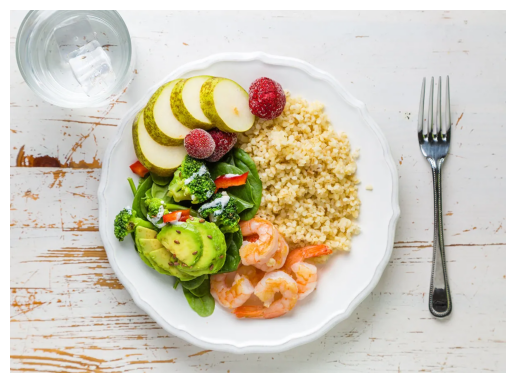

The image shows a white plate with a healthy meal that includes cooked shrimp, sliced avocado, spinach leaves, broccoli florets, some red bell pepper pieces, sliced pear, strawberries, and a serving of cooked bulgur wheat. To the left of the plate, there is a glass of water with ice cubes, and there is a fork placed to the right of the plate on a wooden surface.
Summary Length in characters:364


{'image_caption': 'The image shows a white plate with a healthy meal that includes cooked shrimp, sliced avocado, spinach leaves, broccoli florets, some red bell pepper pieces, sliced pear, strawberries, and a serving of cooked bulgur wheat. To the left of the plate, there is a glass of water with ice cubes, and there is a fork placed to the right of the plate on a wooden surface.',
 'image_url': 'https://www.eatthis.com/wp-content/uploads/sites/4/2021/05/healthy-plate.jpg',
 'embedding': [0.022174417972564697,
  -0.016734540462493896,
  0.008021514862775803,
  0.04478679224848747,
  -0.005857665557414293,
  -0.020364968106150627,
  0.035220906138420105,
  0.008661162108182907,
  0.014671536162495613,
  0.024179797619581223,
  0.07223974168300629,
  0.014544758945703506,
  0.023315411061048508,
  -0.011917021125555038,
  -0.044671542942523956,
  0.05315406247973442,
  0.008165580220520496,
  -0.025194011628627777,
  -0.013069537468254566,
  0.06454093009233475,
  0.04531695321202278,
 

In [25]:
vision_embed(image_url, multi_modal_model='gpt-4.1-mini')

In [37]:
image2_url="https://www.mongodb.com/docs/charts/static/87821c53a354afffdf8f003e3f86adac/64ccf/stacked-bar-chart-reference-small.webp"

In [38]:
def vision_rag(user_query,embedding_dict_,vision_model="gpt-4.1-mini"):

    image_url=embedding_dict_['image_url']
    response = client.responses.create(
      model=vision_model,
      input=[{

              "role":"developer",#   What the AI is.
              "content": "You are an image analysis system. You provide short answers to user queries based ONLY on the  image provided.  If the answer is not contained withing the image you respond that you don't know."
          },
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": user_query},
                {
                    "type": "input_image",
                    "image_url": image_url,
                },
            ],
        },
    ],

    )
    print(response.output_text)

healthy-plate.jpg


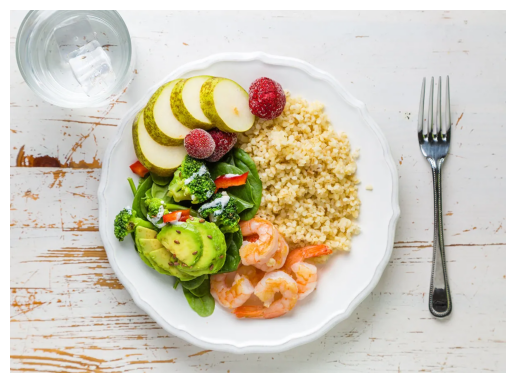

The image shows a plate of food consisting of brown rice, shrimp, sliced avocado, spinach, broccoli, red bell pepper, sliced pear, and strawberries. There's also a glass of water with ice and a fork placed next to the plate on a white wooden table.
Summary Length in characters:248


In [39]:
my_image_embedding = vision_embed(image_url, multi_modal_model='gpt-4.1-mini')


In [40]:
vision_rag("What's the green stuff?",my_image_embedding)

The green stuff on the plate includes spinach, broccoli, and sliced avocado.


Image downloaded and saved as stacked-bar-chart-reference-small.webp


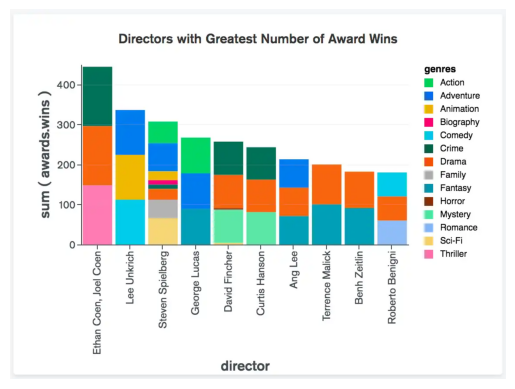

The image is a bar chart titled "Directors with Greatest Number of Award Wins." It shows the total sum of award wins for various directors, with the bars color-coded by genres. 

The x-axis lists directors:
- Ethan Coen, Joel Coen
- Lee Unkrich
- Steven Spielberg
- George Lucas
- David Fincher
- Curtis Hanson
- Ang Lee
- Terrence Malick
- Benh Zeitlin
- Roberto Benigni

The y-axis represents the sum of awards wins, ranging up to above 400.

The genres are color-coded as follows:
- Action (green)
- Adventure (blue)
- Animation (yellow)
- Biography (pink)
- Comedy (cyan)
- Crime (dark green)
- Drama (orange)
- Family (grey)
- Fantasy (dark cyan)
- Horror (brown)
- Mystery (light green)
- Romance (light blue)
- Sci-Fi (light yellow)
- Thriller (bright pink)

Ethan and Joel Coen have the highest number of total award wins, followed by Lee Unkrich and Steven Spielberg. Genre contributions to each director’s wins vary, with Drama, Comedy, and Adventure being prominent genres across multiple 

In [44]:
chart_metadata=vision_embed(image2_url)

In [45]:
vision_rag("who is the best director and why?", chart_metadata)

The best director based on the greatest number of award wins shown in the image is Ethan Coen and Joel Coen. They have the highest total number of award wins compared to the other directors listed.
